In [1]:
""" 
We will use subversion to get only 1 folder from our github repo, 
instead of cloning the entire repository using git.clone
(Done by replacing ".../tree/main/S11" with ".../trunk/S11" in the git folder url)
"""
!apt install subversion
!pip install albumentations==0.4.6
!pip install pytorch-gradcam

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [2]:
# !rm -rf S11
!svn checkout https://github.com/AkhilP9182/EVA5---Extensive-Vision-AI/trunk/S11
%ls

UU   S11/cyclicLR.py
Checked out revision 203.
data/  S11/  sample_data/


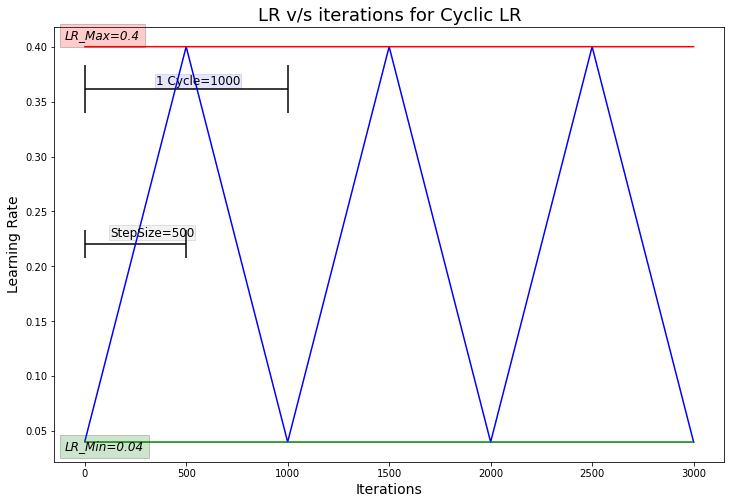

In [3]:
from S11.cyclicLR import Cyclic_LR_Plot
lr_min, lr_max = 0.04, 0.4
stepsize, total_iterations = 500, 3000

Cyclic_LR_Plot(lr_min= lr_min, lr_max= lr_max,
                total_iterations= total_iterations, stepsize= stepsize)

## **[1] Importing required packages**

In [4]:
# Importing the necessary packages
import sys
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets
import torch.utils.data
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Importing the custom classes and functions
import S11.config as config
import S11.utilities as util
from S11.train_test import train,test
from S11.lr_finder import LRFinder
from S11.model_s11 import model_s11

## **[2] Load Train/Test datasets (with the new mean and std deviation normalization)**

### [2.1] Calculate mean and std. deviation of combined (train+test) data

In [6]:
SEED = 1  # Set Randomization seed for Reproducible results
torch.manual_seed(SEED)                 

if config.USE_CUDA:
    torch.cuda.manual_seed(SEED)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = util.to_tensor)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = util.to_tensor)
# Train and Test set here are torch tensors
mean_cifar10, std_cifar10 = util.get_mean_std_overall(trainset,testset)

mean_cifar10 = tuple(mean_cifar10.numpy())
std_cifar10 = tuple(std_cifar10.numpy())

print("\nChannelwise Mean of overall CIFAR 10 dataset:\t\t\t{}".format(mean_cifar10))         # mean_cifar10 = (0.49186122, 0.48266134, 0.44720834)
print("Channelwise Standrad Deviation of overall CIFAR 10 dataset:\t{}\n".format(std_cifar10)) # std_cifar10 = (0.24699295, 0.24340236, 0.26160896)

util.dataset_info(trainset,testset)
del trainset,testset

Files already downloaded and verified
Files already downloaded and verified

Channelwise Mean of overall CIFAR 10 dataset:			(0.49186122, 0.48266134, 0.44720834)
Channelwise Standrad Deviation of overall CIFAR 10 dataset:	(0.24699295, 0.24340236, 0.26160896)

Number of classes in CIFAR10   : 10
Number of images for training  : 50000
Number of images for validation: 10000


### [2.2] Getting the PIL image list which would feed into the Albumentation Data fetcher class

In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = None)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = None)
# Train and Test set here are PIL images
train_images, train_labels, _, _  = util.get_PIL_images(trainset)
print("Train Images loaded")
test_images, test_labels, _,_ = util.get_PIL_images(testset)
print("Test Images loaded")

Files already downloaded and verified
Files already downloaded and verified
Train Images loaded
Test Images loaded


### [2.3] Use Albumentation Dataset creator to create a training and testing set

In [8]:
trainset = util.AlbumentateTrainData(image_list = train_images, labels=train_labels, 
                                     mean = mean_cifar10, std = std_cifar10)
testset  = util.AlbumentateTestData(image_list  = test_images,  labels= test_labels, 
                                    mean = mean_cifar10, std = std_cifar10)
# The mean and std for CIFAR10 are already saved in config.py file, for the train and test loaders respectively

train_loader  = util.train_loader_cifar10(trainset, shuffle = True , num_workers = config.num_workers)
test_loader   = util.test_loader_cifar10(testset,   shuffle = False, num_workers = config.num_workers)

classes = config.CIFAR_classes
print(classes)
num_classes = len(classes)
print("\nNumber of classes = {}".format(num_classes))

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Number of classes = 10


## **[3] Define Model**

In [9]:
device = config.DEVICE                                # Selects whether to run the model on GPU or CPU
model = model_s11().to(device)                         # Loads the model weights on the gpu or cpu
summary(model, input_size=config.input_size_CIFAR10)  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## **[4] Training and Testing the model**

### **[4.1] LR Finder**


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.82E-01


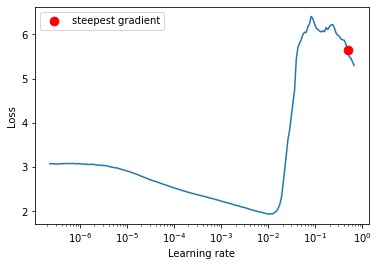

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=0.0005)
lr_finder = LRFinder(model, optimizer, criterion, device=config.DEVICE)
lr_finder.range_test(train_loader, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

### **[4.2] Train and Test functions**

In [12]:
epochs = config.EPOCHS             # No. of training epochs = 24
LEARNING_RATE = 4.82E-01*0.2       
# [Learning Rate suggested by the LR finder * (1/5)], since using the original LR suggestion was reaching about 77% accuracy within 24 epochs
train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = LEARNING_RATE, 
                                                epochs = epochs, steps_per_epoch = len(train_loader),
                                                pct_start = 0.21, div_factor = 10, final_div_factor = 1,
                                                cycle_momentum = True, base_momentum=0.8, max_momentum=0.95)
'''
steps_per_epoch is the number of batches/iterations in each epoch

pct_start = The percentage of the cycle (in number of steps) spent increasing the learning rate.
Since we want the LR to reach its max at 5th epoch, we will set pct_start to (5/24) = 0.20833 = 0.21

div_factor : Determines the initial learning rate via initial_lr = max_lr/div_factor

final_div_factor : Determines the minimum learning rate via min_lr = initial_lr/final_div_factor
'''

max_test_acc = 0
for epoch in range(0, epochs):
    train_loss,train_acc = train(model, config.DEVICE, train_loader, optimizer, epoch, 
                                 L2_param = 0.0005, cyclicLR=True, scheduler=scheduler)
    test_loss,test_acc   = test(model, config.DEVICE, test_loader)
    if (test_acc > max_test_acc): # Save the best performing model
        model_path = 'S11/model/S11_best_model.model'
        torch.save(model.state_dict(), model_path)
        max_test_acc = test_acc
        print("Model saved at epoch {}".format(epoch))
    scheduler.step(test_loss)       # FOR LR UPDATE
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)


Epoch:0 Learning Rate:0.017830179921252673
Train Set: Mean loss: 2.2836, Train Accuracy: 12266/50000 (24.53%)
Test Set : Mean loss: 2.3016, Test Accuracy : 2608/10000 (26.08%)

Model saved at epoch 0



Epoch:1 Learning Rate:0.018206066596921644
Train Set: Mean loss: 1.9467, Train Accuracy: 15731/50000 (31.46%)
Test Set : Mean loss: 1.8920, Test Accuracy : 3533/10000 (35.33%)

Model saved at epoch 1



Epoch:2 Learning Rate:0.018138616005045183
Train Set: Mean loss: 1.6999, Train Accuracy: 20199/50000 (40.40%)
Test Set : Mean loss: 1.5807, Test Accuracy : 4455/10000 (44.55%)

Model saved at epoch 2



Epoch:3 Learning Rate:0.018087523027686014
Train Set: Mean loss: 1.7106, Train Accuracy: 21766/50000 (43.53%)
Test Set : Mean loss: 1.6623, Test Accuracy : 4635/10000 (46.35%)

Model saved at epoch 3



Epoch:4 Learning Rate:0.01810089949242391
Train Set: Mean loss: 1.6913, Train Accuracy: 22279/50000 (44.56%)
Test Set : Mean loss: 1.7094, Test Accuracy : 4607/10000 (46.07%)




Epoch:5 Learning Rate:0.018108639112468114
Train Set: Mean loss: 1.2049, Train Accuracy: 30048/50000 (60.10%)
Test Set : Mean loss: 1.1673, Test Accuracy : 6260/10000 (62.60%)

Model saved at epoch 5



Epoch:6 Learning Rate:0.01801987965598341
Train Set: Mean loss: 1.3294, Train Accuracy: 28696/50000 (57.39%)
Test Set : Mean loss: 1.3265, Test Accuracy : 5929/10000 (59.29%)




Epoch:7 Learning Rate:0.018045895801498915
Train Set: Mean loss: 0.8699, Train Accuracy: 35061/50000 (70.12%)
Test Set : Mean loss: 0.8258, Test Accuracy : 7135/10000 (71.35%)

Model saved at epoch 7



Epoch:8 Learning Rate:0.01796417612355368
Train Set: Mean loss: 0.9388, Train Accuracy: 34760/50000 (69.52%)
Test Set : Mean loss: 0.9059, Test Accuracy : 7135/10000 (71.35%)




Epoch:9 Learning Rate:0.017977221193973283
Train Set: Mean loss: 0.8132, Train Accuracy: 36434/50000 (72.87%)
Test Set : Mean loss: 0.8190, Test Accuracy : 7430/10000 (74.30%)

Model saved at epoch 9



Epoch:10 Learning Rate:0.017963073931278953
Train Set: Mean loss: 0.7756, Train Accuracy: 36726/50000 (73.45%)
Test Set : Mean loss: 0.7076, Test Accuracy : 7676/10000 (76.76%)

Model saved at epoch 10



Epoch:11 Learning Rate:0.01794493348815432
Train Set: Mean loss: 0.6276, Train Accuracy: 39196/50000 (78.39%)
Test Set : Mean loss: 0.6103, Test Accuracy : 7954/10000 (79.54%)

Model saved at epoch 11



Epoch:12 Learning Rate:0.017929115673504054
Train Set: Mean loss: 0.5854, Train Accuracy: 39857/50000 (79.71%)
Test Set : Mean loss: 0.5801, Test Accuracy : 8080/10000 (80.80%)

Model saved at epoch 12



Epoch:13 Learning Rate:0.017924208150068538
Train Set: Mean loss: 0.6090, Train Accuracy: 39484/50000 (78.97%)
Test Set : Mean loss: 0.5788, Test Accuracy : 8054/10000 (80.54%)




Epoch:14 Learning Rate:0.01792400445207551
Train Set: Mean loss: 0.5655, Train Accuracy: 40443/50000 (80.89%)
Test Set : Mean loss: 0.5548, Test Accuracy : 8192/10000 (81.92%)

Model saved at epoch 14



Epoch:15 Learning Rate:0.017920094373880993
Train Set: Mean loss: 0.4688, Train Accuracy: 41857/50000 (83.71%)
Test Set : Mean loss: 0.4886, Test Accuracy : 8341/10000 (83.41%)

Model saved at epoch 15



Epoch:16 Learning Rate:0.017909352670133036
Train Set: Mean loss: 0.4946, Train Accuracy: 41528/50000 (83.06%)
Test Set : Mean loss: 0.5110, Test Accuracy : 8351/10000 (83.51%)

Model saved at epoch 16



Epoch:17 Learning Rate:0.017912979823656028
Train Set: Mean loss: 0.4633, Train Accuracy: 41943/50000 (83.89%)
Test Set : Mean loss: 0.4902, Test Accuracy : 8406/10000 (84.06%)

Model saved at epoch 17



Epoch:18 Learning Rate:0.017909603582940428
Train Set: Mean loss: 0.5868, Train Accuracy: 40161/50000 (80.32%)
Test Set : Mean loss: 0.5537, Test Accuracy : 8282/10000 (82.82%)




Epoch:19 Learning Rate:0.017919912659763185
Train Set: Mean loss: 0.4677, Train Accuracy: 41967/50000 (83.93%)
Test Set : Mean loss: 0.4906, Test Accuracy : 8404/10000 (84.04%)




Epoch:20 Learning Rate:0.017909674355347197
Train Set: Mean loss: 0.4159, Train Accuracy: 42804/50000 (85.61%)
Test Set : Mean loss: 0.4658, Test Accuracy : 8491/10000 (84.91%)

Model saved at epoch 20



Epoch:21 Learning Rate:0.01790564185845546
Train Set: Mean loss: 0.4088, Train Accuracy: 42877/50000 (85.75%)
Test Set : Mean loss: 0.4636, Test Accuracy : 8486/10000 (84.86%)




Epoch:22 Learning Rate:0.01790528466239806
Train Set: Mean loss: 0.3722, Train Accuracy: 43445/50000 (86.89%)
Test Set : Mean loss: 0.4199, Test Accuracy : 8647/10000 (86.47%)

Model saved at epoch 22



Epoch:23 Learning Rate:0.017898189527869854
Train Set: Mean loss: 0.3699, Train Accuracy: 43440/50000 (86.88%)
Test Set : Mean loss: 0.4186, Test Accuracy : 8680/10000 (86.80%)

Model saved at epoch 23


## **[5] Loss and Accuracy Plots**

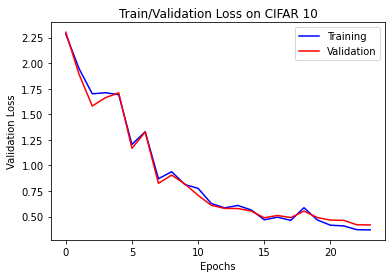

In [13]:
util.plot_loss(train_loss_vals,test_loss_vals,config.EPOCHS)

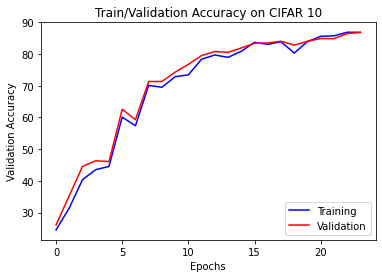

In [14]:
util.plot_acc(train_acc_vals,test_acc_vals,config.EPOCHS)

## **[6] Plot Correctly Classified Images, their predictions and their GradCAM Heatmaps**

Following are the correctly classified images:-


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

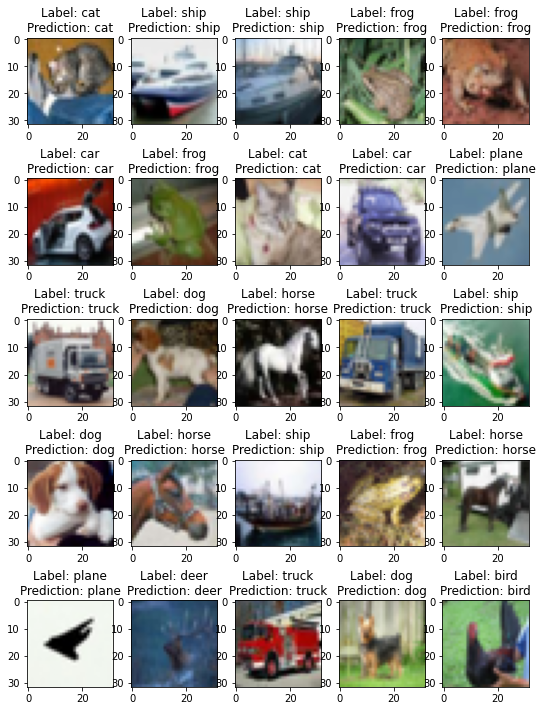

Following are the GradCam Heatmaps for those correctly classified images (for the resblock before final maxpool):-


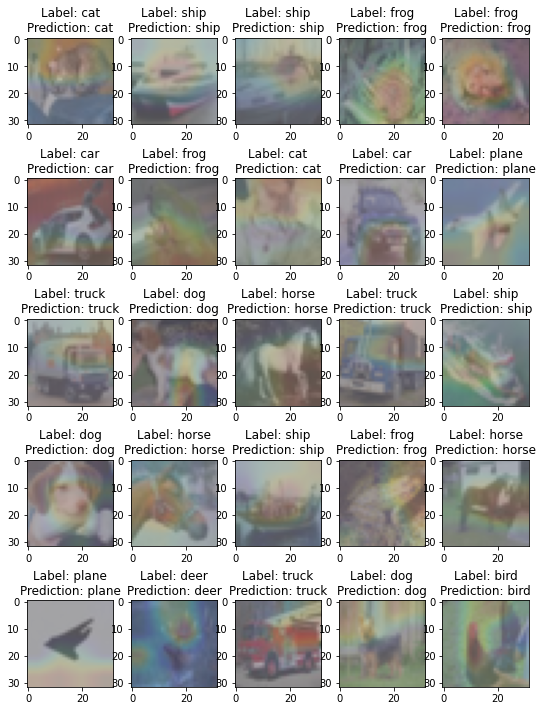

In [15]:
util.plot_correct_classified(model_s11,"S11/model/S11_best_model.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)

## **[7] Plot Misclassified Images, their predictions and their GradCAM Heatmaps**

Following are the mis-classified images:-


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


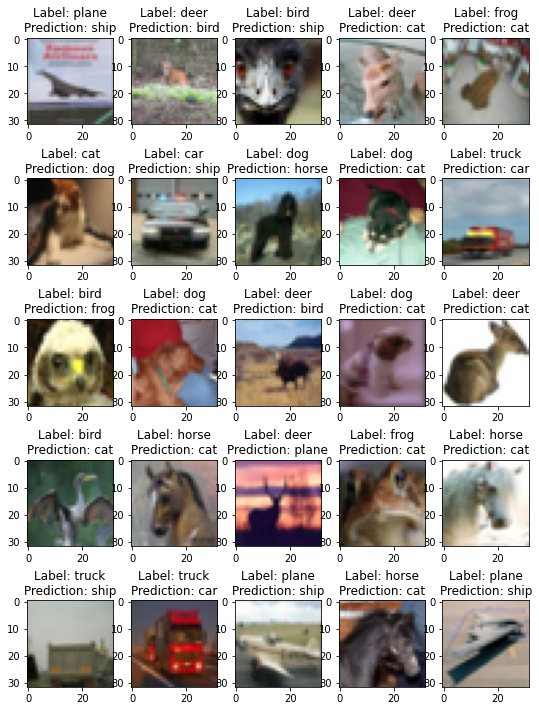

Following are the GradCam Heatmaps for those mis-classified images (for the resblock before final maxpool):-


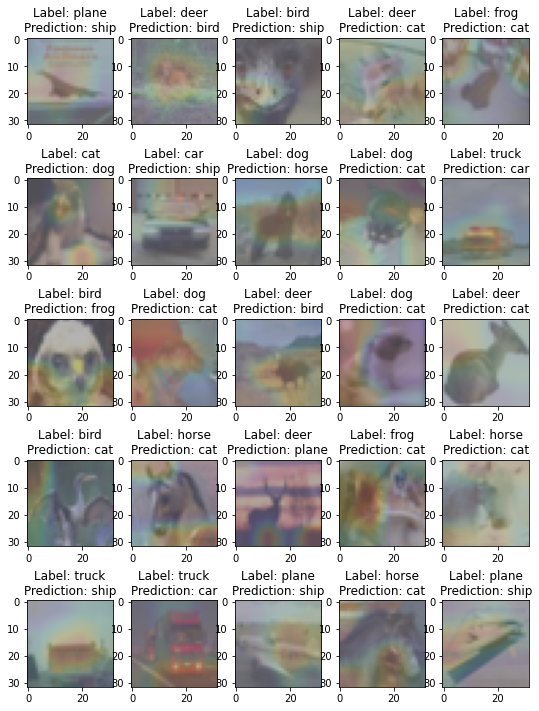

In [16]:
util.plot_misclassified(model_s11,"S11/model/S11_best_model.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)